In [22]:
import pandas as pd
import numpy as np
import pickle 
import matplotlib.pyplot as plt
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from textblob import TextBlob
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
football_feed_df = pd.read_pickle('football_feed_df.pkl')
print(football_feed_df.columns)
football_feed_df.head()

Index(['created_at', 'id', 'id_str', 'full_text', 'truncated',
       'display_text_range', 'entities', 'extended_entities', 'metadata',
       'source', 'in_reply_to_status_id', 'in_reply_to_status_id_str',
       'in_reply_to_user_id', 'in_reply_to_user_id_str',
       'in_reply_to_screen_name', 'geo', 'coordinates', 'place',
       'contributors', 'is_quote_status', 'retweet_count', 'favorite_count',
       'favorited', 'retweeted', 'possibly_sensitive', 'lang', 'team',
       'user_id', 'retweeted_status_id', 'quoted_status_id',
       'quoted_status_id_str', 'quoted_status', 'text', 'hashtags',
       'user_mentions', 'emoji', 'processed_text'],
      dtype='object')


,created_at,id,id_str,full_text,truncated,display_text_range,entities,extended_entities,metadata,source,...,user_id,retweeted_status_id,quoted_status_id,quoted_status_id_str,quoted_status,text,hashtags,user_mentions,emoji,processed_text
0,Fri Nov 13 21:27:20 +0000 2020,1327362434361823232,1327362434361823232,- Heisman Trophy winner (1956)\n- No. 1 overal...,False,"[0, 212]","{'hashtags': [{'text': 'Packers', 'indices': [...","{'media': [{'id': 1327340427352174592, 'id_str...","{'result_type': 'popular', 'iso_language_code'...","<a href=""https://studio.twitter.com"" rel=""nofo...",...,35865630,NaN,NaN,NaN,NaN,NaN,"[{'text': 'Packers', 'indices': [182, 190]}]",,[],- Heisman Trophy winner ( 1956 ) - No . 1 over...
1,Fri Nov 13 19:36:20 +0000 2020,1327334499919642625,1327334499919642625,"Paul Hornung, described by Vince Lombardi as ""...",False,"[0, 151]","{'hashtags': [], 'symbols': [], 'user_mentions...",NaN,"{'result_type': 'popular', 'iso_language_code'...","<a href=""https://mobile.twitter.com"" rel=""nofo...",...,35865630,NaN,NaN,NaN,NaN,NaN,[],,[],"Paul Hornung , described Vince Lombardi `` gre..."
2,Fri Nov 13 18:30:00 +0000 2020,1327317809945325569,1327317809945325569,The entire Pro Football HOF family mourns the ...,False,"[0, 264]","{'hashtags': [{'text': 'HOFForever', 'indices'...","{'media': [{'id': 1327312635180834816, 'id_str...","{'result_type': 'popular', 'iso_language_code'...","<a href=""https://ads.twitter.com"" rel=""nofollo...",...,23632910,NaN,NaN,NaN,NaN,NaN,"[{'text': 'HOFForever', 'indices': [242, 253]}]",Green Bay Packers,[],The entire Pro Football HOF family mourns pass...
3,Sat Nov 14 20:07:06 +0000 2020,1327704633796653064,1327704633796653064,"To all the true heroes, we say thank you. \n\...",False,"[0, 112]","{'hashtags': [{'text': 'SaluteToService', 'ind...","{'media': [{'id': 1326259298645790722, 'id_str...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/iphone"" r...",...,724773710549372928,1.327628e+18,NaN,NaN,NaN,NaN,"[{'text': 'SaluteToService', 'indices': [57, 7...",Green Bay Packers,[],"To true hero , say thank . # SaluteToService |"
4,Sat Nov 14 20:06:46 +0000 2020,1327704548304150529,1327704548304150529,Domino’s delivery guy to my house.,False,"[13, 47]","{'hashtags': [], 'symbols': [], 'user_mentions...",NaN,"{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/iphone"" r...",...,1314216459892133888,NaN,NaN,NaN,NaN,NaN,[],PFF GB Packers,[],Domino ’ delivery guy house .


In [4]:
#check to see how mnay repeat tweets we scraped. 

print(len(football_feed_df.full_text))
print(len(set(football_feed_df.full_text)))

1200
894


In [8]:
#drop duplicate tweets 
football_feed_df.drop_duplicates(subset=['full_text'], inplace=True)


In [14]:
#check to make sure the number of tweets per team remains similar 
football_feed_df['team'].value_counts()

Bears      164
Raiders    161
Cowboys    154
Packers    149
Chiefs     134
Eagles     132
Name: team, dtype: int64

In [10]:
#shuffle the data 
np.random.seed(1)
df = football_feed_df.reindex(np.random.permutation(football_feed_df.index))

In [11]:
#data is already preprocessed in scrape script

def sentiment_analysis(text):
    text = " ".join(text["processed_text"])
    text = TextBlob(text)

    return text.sentiment.polarity  #returns float in range [-1, 1]

teams_df = football_feed_df[["processed_text", "team"]].groupby("team")
sentiments = teams_df.apply(sentiment_analysis)

In [27]:
sentiments

pandas.core.series.Series

<AxesSubplot:xlabel='team'>

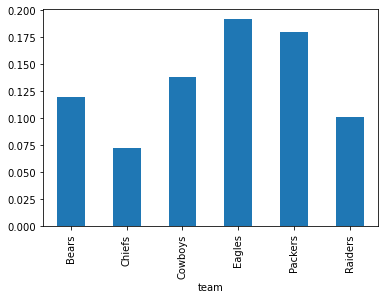

In [30]:
sentiments.plot.bar()

In [32]:
import re
contraction_patterns=[(r'can\'t', 'cannot'),
                    (r'haven\'t', 'have not'),
                    (r'(\w+)\'ll', '\g<1> will'),
                    (r'(\w+)\'re', '\g<1> are'),
                     (r'(\w+)\'ve', '\g<1> have'), 
                     (r'don\'t', 'do not')]

class contraction_replacer(object):
    def __init__(self, contraction_patterns):        
        # store compiled regex object
        self._contraction_regexes = [(re.compile(p), replaced_text) for p, replaced_text in contraction_patterns]
        
    def do_contraction_normalization(self, text):
        for contraction_regex, replaced_text in self._contraction_regexes:
            text = contraction_regex.sub(replaced_text, text)
        return text     
contraction_replacer = contraction_replacer(contraction_patterns)

In [33]:
def clean_tweet(tweet):
    btweet = contraction_replacer.do_contraction_normalization(tweet)
    wnetl = WordNetLemmatizer()
    ctweet = wnetl.lemmatize(btweet)
    word_regex= nltk.RegexpTokenizer(pattern=r'\w+', gaps=False)
    clean_tweet = word_regex.tokenize(ctweet)
    stopwords = nltk.corpus.stopwords.words('english')
    stop_clean_sent = [w for w in clean_tweet if w not in stopwords]
    return stop_clean_sent

In [34]:
football_feed_df["full_text"] = football_feed_df["full_text"].apply(clean_tweet)
football_feed_df.head(10)

,created_at,id,id_str,full_text,truncated,display_text_range,entities,extended_entities,metadata,source,...,user_id,retweeted_status_id,quoted_status_id,quoted_status_id_str,quoted_status,text,hashtags,user_mentions,emoji,processed_text
0,Fri Nov 13 21:27:20 +0000 2020,1327362434361823232,1327362434361823232,"[Heisman, Trophy, winner, 1956, No, 1, overall...",False,"[0, 212]","{'hashtags': [{'text': 'Packers', 'indices': [...","{'media': [{'id': 1327340427352174592, 'id_str...","{'result_type': 'popular', 'iso_language_code'...","<a href=""https://studio.twitter.com"" rel=""nofo...",...,35865630,NaN,NaN,NaN,NaN,NaN,"[{'text': 'Packers', 'indices': [182, 190]}]",,[],- Heisman Trophy winner ( 1956 ) - No . 1 over...
1,Fri Nov 13 19:36:20 +0000 2020,1327334499919642625,1327334499919642625,"[Paul, Hornung, described, Vince, Lombardi, gr...",False,"[0, 151]","{'hashtags': [], 'symbols': [], 'user_mentions...",NaN,"{'result_type': 'popular', 'iso_language_code'...","<a href=""https://mobile.twitter.com"" rel=""nofo...",...,35865630,NaN,NaN,NaN,NaN,NaN,[],,[],"Paul Hornung , described Vince Lombardi `` gre..."
2,Fri Nov 13 18:30:00 +0000 2020,1327317809945325569,1327317809945325569,"[The, entire, Pro, Football, HOF, family, mour...",False,"[0, 264]","{'hashtags': [{'text': 'HOFForever', 'indices'...","{'media': [{'id': 1327312635180834816, 'id_str...","{'result_type': 'popular', 'iso_language_code'...","<a href=""https://ads.twitter.com"" rel=""nofollo...",...,23632910,NaN,NaN,NaN,NaN,NaN,"[{'text': 'HOFForever', 'indices': [242, 253]}]",Green Bay Packers,[],The entire Pro Football HOF family mourns pass...
3,Sat Nov 14 20:07:06 +0000 2020,1327704633796653064,1327704633796653064,"[To, true, heroes, say, thank, SaluteToService]",False,"[0, 112]","{'hashtags': [{'text': 'SaluteToService', 'ind...","{'media': [{'id': 1326259298645790722, 'id_str...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/iphone"" r...",...,724773710549372928,1.327628e+18,NaN,NaN,NaN,NaN,"[{'text': 'SaluteToService', 'indices': [57, 7...",Green Bay Packers,[],"To true hero , say thank . # SaluteToService |"
4,Sat Nov 14 20:06:46 +0000 2020,1327704548304150529,1327704548304150529,"[Domino, delivery, guy, house]",False,"[13, 47]","{'hashtags': [], 'symbols': [], 'user_mentions...",NaN,"{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/iphone"" r...",...,1314216459892133888,NaN,NaN,NaN,NaN,NaN,[],PFF GB Packers,[],Domino ’ delivery guy house .
5,Sat Nov 14 20:06:20 +0000 2020,1327704439097073665,1327704439097073665,"[1st, play, 1pm, games, tomorrow, The, jags, r...",False,"[0, 207]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 1327704429018144774, 'id_str...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/iphone"" r...",...,1327076463657578496,NaN,NaN,NaN,NaN,NaN,[],,[],1st play 1pm game tomorrow : The jag rank 27th...
6,Sat Nov 14 20:06:17 +0000 2020,1327704425637441536,1327704425637441536,"[Few, players, able, shut, 52, men, mere, murm...",False,"[0, 140]","{'hashtags': [], 'symbols': [], 'user_mentions...",NaN,"{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/iphone"" r...",...,1160996518461157376,1.327704e+18,NaN,NaN,NaN,NaN,[],Zachary,[],Few player able shut 52 men mere murmur voice ...
7,Sat Nov 14 20:06:13 +0000 2020,1327704409187315714,1327704409187315714,"[SUNDAY, S, NFL, LOCKS, Eagles, 4, Packers, ML...",False,"[0, 277]","{'hashtags': [{'text': 'BarstoolSportsbook', '...",NaN,"{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/android"" ...",...,1327047566832254976,NaN,NaN,NaN,NaN,NaN,"[{'text': 'BarstoolSportsbook', 'indices': [20...",,[],SUNDAY 'S NFL LOCKS Eagles -4 Packers ML Texan...
8,Sat Nov 14 20:06:04 +0000 2020,1327704373300965377,1327704373300965377,"[Dolphins, x, Chargers, é, em, que, horário, a...",False,"[10, 146

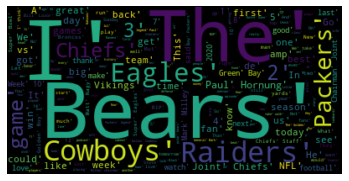

In [37]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

unique_string=(" ").join(map(str, football_feed_df.full_text))
wordcloud = WordCloud().generate(unique_string)

# Display the generated image:
# the matplotlib way:
import matplotlib.pyplot as plt
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")


plt.show()

Packers


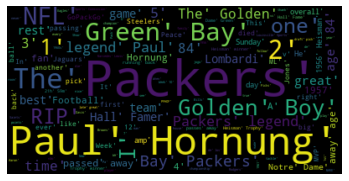

Bears


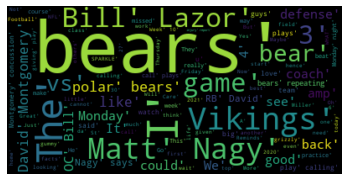

Eagles


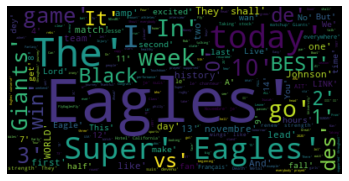

Cowboys


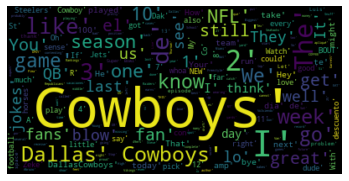

Raiders


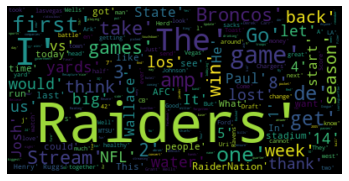

Chiefs


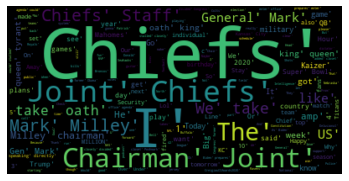

In [38]:
teams = ["Packers","Bears","Eagles", "Cowboys","Raiders", "Chiefs"]

for i in range(len(teams)):
    df = football_feed_df[football_feed_df['team']==teams[i]]
    print(teams[i])
    unique_string=(" ").join(map(str, df.full_text))
    wordcloud = WordCloud().generate(unique_string)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")


    plt.show()